# Problem statement
Check wheather the bird image is correctly classified

In [1]:
# General Libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
tf.__version__

'2.6.4'

In [2]:
import os

def walk_on_dir(dir):
    print(dir)
    i = 0 
    for path, dirs, files in os.walk(dir):
        if len(dirs) > 0:
            print(len(dirs))
            print(dirs)
            _dirs = dirs
        else:
            print(path)
            print(_dirs[i])
            print(files)
            i+=1
    print(i)

In [3]:
MAX_EPOCHS = 25
PATIENCE = 4

def train_model(model_id, model, train_generator, val_generator):

    # Save the best model
    cb_save_best_model = keras.callbacks.ModelCheckpoint(filepath=model_id,
                                                         monitor='val_loss', 
                                                         save_best_only=True, 
                                                         verbose=1)

    # End training early if there is no progress
    cb_early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience= PATIENCE,
                                                  verbose=1)


    history = model.fit(
            train_generator,
            steps_per_epoch = train_generator.samples // BATCH_SIZE,
            epochs=MAX_EPOCHS,
            callbacks = [cb_save_best_model, cb_early_stop],
            validation_data=val_generator,
            verbose = 1,
            validation_steps= val_generator.samples // BATCH_SIZE)
    
    return history

# metrics

In [4]:
def print_metrics(model, dataset_generator):
    score = model.evaluate(test_generator)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('Test ROC AUC:', score[2])

# Training model curve

In [5]:
def plot_training_curves(history):
    # Training curves
    import matplotlib.pyplot as plt

    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs_x = range(1, len(loss_values) + 1)
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
    plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation Loss and Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(2,1,2)
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
    plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
    #plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

# Confusion matrix and classification report

In [6]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def plot_confusion_matrix_and_classification_report(model, dataset_generator, classes):
    Y_pred = model.predict(dataset_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    
    #Confution Matrix
    cm = confusion_matrix(test_generator.classes, y_pred)
    plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix')

    #Classification Report
    print('Classification Report')
    print(classification_report(test_generator.classes, y_pred, target_names=classes))

In [8]:
IMG_SHAPE = (244,244)
INPUT_SHAPE = (IMG_SHAPE[0], IMG_SHAPE[1], 3)

TRAIN_DIR = '../input/100-bird-species/train'
TEST_DIR = '../input/100-bird-species/test'
VAL_DIR = '../input/100-bird-species/valid'

BATCH_SIZE = 16

RANDOM_SEED = 33

MAX_CLASSES = 30

In [9]:
classes = os.listdir(TRAIN_DIR)
num_classes = len(classes)
num_classes

450

In [10]:
# For experimentation, let's randomly choose N classes

import random

random.Random(RANDOM_SEED).shuffle(classes)

classes = classes[:MAX_CLASSES]
num_classes = len(classes)

classes

['DARJEELING WOODPECKER',
 'BARROWS GOLDENEYE',
 'MARABOU STORK',
 'COCKATOO',
 'GOULDIAN FINCH',
 'HORNED LARK',
 'GOLD WING WARBLER',
 'STRIPPED SWALLOW',
 'ROSY FACED LOVEBIRD',
 'GREAT KISKADEE',
 'ARARIPE MANAKIN',
 'LESSER ADJUTANT',
 'NORTHERN JACANA',
 'SANDHILL CRANE',
 'ABBOTTS BOOBY',
 'SPANGLED COTINGA',
 'ANDEAN GOOSE',
 'EARED PITA',
 'GREATER PEWEE',
 'FIRE TAILLED MYZORNIS',
 'AZURE TANAGER',
 'NORTHERN SHOVELER',
 'GO AWAY BIRD',
 'AFRICAN EMERALD CUCKOO',
 'TASMANIAN HEN',
 'BLACK TAIL CRAKE',
 'TURQUOISE MOTMOT',
 'GREEN JAY',
 'GREAT GRAY OWL',
 'ELEGANT TROGON']

Found 2250 images belonging to 450 classes.


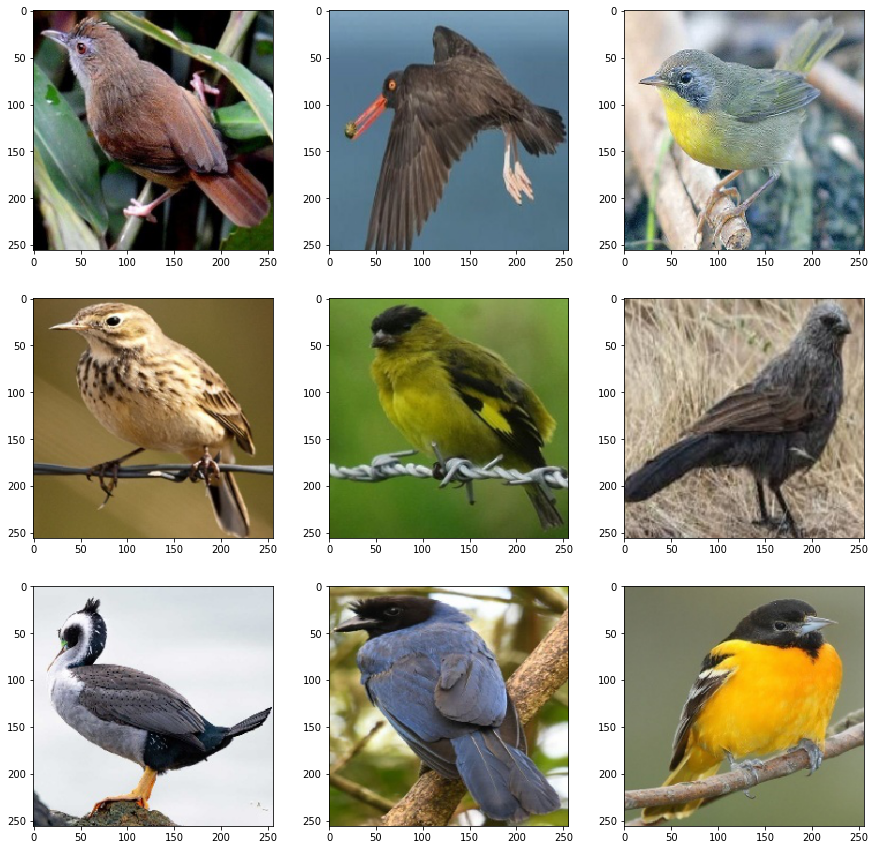

In [11]:
# Visualizing some sample data

sample_generator = ImageDataGenerator().flow_from_directory(TEST_DIR, shuffle=False)

plt.figure(figsize=(15,15))
for i in range(9):
    # 3x3 grid
    plt.subplot(330 + 1 + i)
    batch = sample_generator.next()[0]
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

# pre-processing

In [12]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [13]:
generator_args = {
    "preprocessing_function":preprocess_input,
}
flow_args = {
    "target_size":IMG_SHAPE,
    "seed":RANDOM_SEED,
    "batch_size":BATCH_SIZE,
    "class_mode":"categorical",
    "classes":classes,
}

In [14]:
img_generator = ImageDataGenerator(**generator_args)
augmented_img_generator = ImageDataGenerator(rotation_range=20,
                                             width_shift_range=0.1,
                                             height_shift_range=0.1,
                                             shear_range=0.1,
                                             zoom_range=0.1,
                                             horizontal_flip=True,
                                             fill_mode='nearest',
                                             **generator_args)

In [15]:
train_generator = augmented_img_generator.flow_from_directory(TRAIN_DIR, shuffle=True, **flow_args)
test_generator = img_generator.flow_from_directory(TEST_DIR, shuffle=False, **flow_args)
val_generator = img_generator.flow_from_directory(VAL_DIR, shuffle=False, **flow_args)

Found 4618 images belonging to 30 classes.
Found 150 images belonging to 30 classes.
Found 150 images belonging to 30 classes.


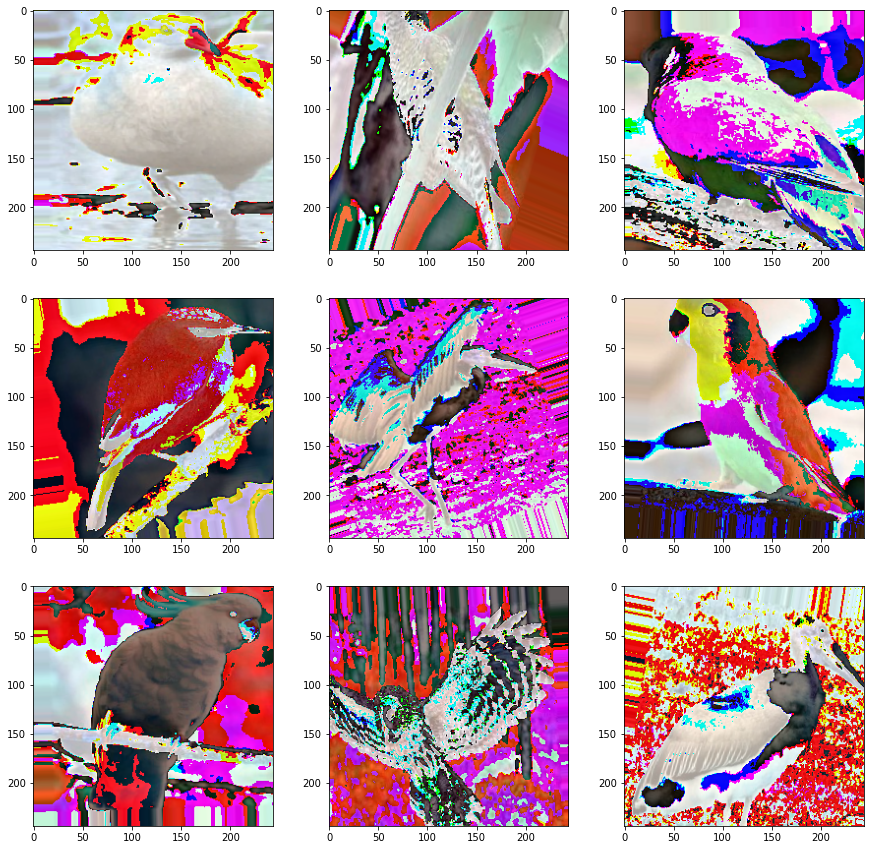

In [16]:
# Visualizing some pre-processed examples

plt.figure(figsize=(15,15))
for i in range(9):
    # 3x3 grid
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

# Resultado da Versão 2:
```
Test loss: 1.8166121244430542
Test accuracy: 0.4866666793823242
Test ROC AUC: 0.9163340926170349
```
```
Classification Report
                        precision    recall  f1-score   support

       RED HEADED DUCK       0.57      0.80      0.67         5
            PINK ROBIN       0.62      1.00      0.77         5
   RED FACED CORMORANT       0.33      0.40      0.36         5
       BARRED PUFFBIRD       1.00      0.20      0.33         5
              WHIMBREL       0.50      0.40      0.44         5
          WALL CREAPER       0.33      0.40      0.36         5
      EVENING GROSBEAK       0.50      0.80      0.62         5
         MOURNING DOVE       0.33      0.20      0.25         5
     NORTHERN CARDINAL       1.00      0.20      0.33         5
 RED BEARDED BEE EATER       1.00      0.60      0.75         5
       RUDY KINGFISHER       0.83      1.00      0.91         5
  NORTHERN MOCKINGBIRD       0.25      0.20      0.22         5
               QUETZAL       0.11      0.20      0.14         5
BLACK THROATED WARBLER       0.60      0.60      0.60         5
  BLACKBURNIAM WARBLER       0.50      0.40      0.44         5
                PUFFIN       0.44      0.80      0.57         5
      TURQUOISE MOTMOT       0.67      0.80      0.73         5
      NORTHERN FLICKER       1.00      0.40      0.57         5
      EASTERN BLUEBIRD       0.50      0.40      0.44         5
       SCARLET TANAGER       0.44      0.80      0.57         5
         CEDAR WAXWING       0.29      0.40      0.33         5
                CANARY       0.67      0.40      0.50         5
 AFRICAN CROWNED CRANE       0.50      0.20      0.29         5
          MAGPIE GOOSE       0.75      0.60      0.67         5
   VERMILION FLYCATHER       0.60      0.60      0.60         5
                 ROBIN       0.50      0.20      0.29         5
       COMMON POORWILL       1.00      0.20      0.33         5
      BANDED BROADBILL       0.29      0.40      0.33         5
        HAWAIIAN GOOSE       0.57      0.80      0.67         5
  RED WINGED BLACKBIRD       0.14      0.20      0.17         5

              accuracy                           0.49       150
             macro avg       0.56      0.49      0.48       150
          weighted avg       0.56      0.49      0.48       150
```

# Resultados da Versão 4: image augmentation
```
Test loss: 0.3912387192249298
Test accuracy: 0.846666693687439
Test ROC AUC: 0.9973816871643066
```
```
Classification Report
                        precision    recall  f1-score   support

       RED HEADED DUCK       0.83      1.00      0.91         5
            PINK ROBIN       1.00      1.00      1.00         5
   RED FACED CORMORANT       1.00      0.40      0.57         5
       BARRED PUFFBIRD       1.00      1.00      1.00         5
              WHIMBREL       1.00      0.80      0.89         5
          WALL CREAPER       0.83      1.00      0.91         5
      EVENING GROSBEAK       0.80      0.80      0.80         5
         MOURNING DOVE       0.80      0.80      0.80         5
     NORTHERN CARDINAL       0.67      0.40      0.50         5
 RED BEARDED BEE EATER       1.00      0.80      0.89         5
       RUDY KINGFISHER       0.83      1.00      0.91         5
  NORTHERN MOCKINGBIRD       0.50      0.40      0.44         5
               QUETZAL       1.00      1.00      1.00         5
BLACK THROATED WARBLER       1.00      1.00      1.00         5
  BLACKBURNIAM WARBLER       1.00      0.60      0.75         5
                PUFFIN       1.00      1.00      1.00         5
      TURQUOISE MOTMOT       1.00      1.00      1.00         5
      NORTHERN FLICKER       0.71      1.00      0.83         5
      EASTERN BLUEBIRD       0.80      0.80      0.80         5
       SCARLET TANAGER       1.00      0.80      0.89         5
         CEDAR WAXWING       0.83      1.00      0.91         5
                CANARY       0.83      1.00      0.91         5
 AFRICAN CROWNED CRANE       0.67      0.80      0.73         5
          MAGPIE GOOSE       0.80      0.80      0.80         5
   VERMILION FLYCATHER       0.62      1.00      0.77         5
                 ROBIN       1.00      1.00      1.00         5
       COMMON POORWILL       0.83      1.00      0.91         5
      BANDED BROADBILL       1.00      1.00      1.00         5
        HAWAIIAN GOOSE       0.75      0.60      0.67         5
  RED WINGED BLACKBIRD       0.60      0.60      0.60         5

              accuracy                           0.85       150
             macro avg       0.86      0.85      0.84       150
          weighted avg       0.86      0.85      0.84       150
```

# Resultado da Versão 5: ResNet50 pre_processing
```
Test loss: 0.31490498781204224
Test accuracy: 0.8999999761581421
Test ROC AUC: 0.9982674717903137
```
```
Classification Report
                        precision    recall  f1-score   support

       RED HEADED DUCK       1.00      1.00      1.00         5
            PINK ROBIN       0.83      1.00      0.91         5
   RED FACED CORMORANT       0.75      0.60      0.67         5
       BARRED PUFFBIRD       1.00      1.00      1.00         5
              WHIMBREL       1.00      1.00      1.00         5
          WALL CREAPER       0.80      0.80      0.80         5
      EVENING GROSBEAK       0.80      0.80      0.80         5
         MOURNING DOVE       1.00      0.60      0.75         5
     NORTHERN CARDINAL       0.75      0.60      0.67         5
 RED BEARDED BEE EATER       1.00      1.00      1.00         5
       RUDY KINGFISHER       1.00      0.80      0.89         5
  NORTHERN MOCKINGBIRD       1.00      0.60      0.75         5
               QUETZAL       1.00      1.00      1.00         5
BLACK THROATED WARBLER       0.71      1.00      0.83         5
  BLACKBURNIAM WARBLER       1.00      0.80      0.89         5
                PUFFIN       1.00      1.00      1.00         5
      TURQUOISE MOTMOT       1.00      1.00      1.00         5
      NORTHERN FLICKER       1.00      1.00      1.00         5
      EASTERN BLUEBIRD       1.00      1.00      1.00         5
       SCARLET TANAGER       0.71      1.00      0.83         5
         CEDAR WAXWING       0.71      1.00      0.83         5
                CANARY       0.83      1.00      0.91         5
 AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
          MAGPIE GOOSE       1.00      1.00      1.00         5
   VERMILION FLYCATHER       1.00      0.60      0.75         5
                 ROBIN       0.71      1.00      0.83         5
       COMMON POORWILL       1.00      1.00      1.00         5
      BANDED BROADBILL       1.00      1.00      1.00         5
        HAWAIIAN GOOSE       1.00      1.00      1.00         5
  RED WINGED BLACKBIRD       0.80      0.80      0.80         5

              accuracy                           0.90       150
             macro avg       0.91      0.90      0.90       150
          weighted avg       0.91      0.90      0.90       150
```

# Transfer learning Model using ResNet50

In [17]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

x = base_model.output
x = Flatten()(x)
x = Dense(120, activation='sigmoid')(x)
x = Dropout(0.1)(x)

predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, 
              outputs=predictions)
model.summary()

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False
    
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', "AUC"])

2022-12-12 17:56:11.608136: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


94781440/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 250, 250, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 122, 122, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 122, 122, 64) 256         conv1_conv[0][0]                 
_____________________________

In [18]:
MODEL_ID = 'resnet50.model.bruno.h5'

history = train_model(MODEL_ID, model, train_generator, val_generator)

2022-12-12 17:56:16.633357: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
288/288 [==============================] - 420s 1s/step - loss: 2.8286 - accuracy: 0.3568 - auc: 0.8547 - val_loss: 2.1435 - val_accuracy: 0.6319 - val_auc: 0.9757

Epoch 00001: val_loss improved from inf to 2.14346, saving model to resnet50.model.bruno.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
288/288 [==============================] - 407s 1s/step - loss: 1.7887 - accuracy: 0.6936 - auc: 0.9789 - val_loss: 1.2239 - val_accuracy: 0.9097 - val_auc: 0.9957

Epoch 00002: val_loss improved from 2.14346 to 1.22390, saving model to resnet50.model.bruno.h5
Epoch 3/25
288/288 [==============================] - 415s 1s/step - loss: 1.1664 - accuracy: 0.8231 - auc: 0.9921 - val_loss: 0.7120 - val_accuracy: 0.9236 - val_auc: 0.9986

Epoch 00003: val_loss improved from 1.22390 to 0.71198, saving model to resnet50.model.bruno.h5
Epoch 4/25
288/288 [==============================] - 420s 1s/step - loss: 0.8454 - accuracy: 0.8622 - auc: 0.9953 - val_loss: 0.5329 - val_accuracy: 0.9097 - val_auc: 0.9990

Epoch 00004: val_loss improved from 0.71198 to 0.53294, saving model to resnet50.model.bruno.h5
Epoch 5/25
288/288 [==============================] - 411s 1s/step - loss: 0.6575 - accuracy: 0.8896 - auc: 0.9970 - val_loss: 0.3932 - val_accuracy: 0.9514 - val_auc: 0.9996

Epoch 00

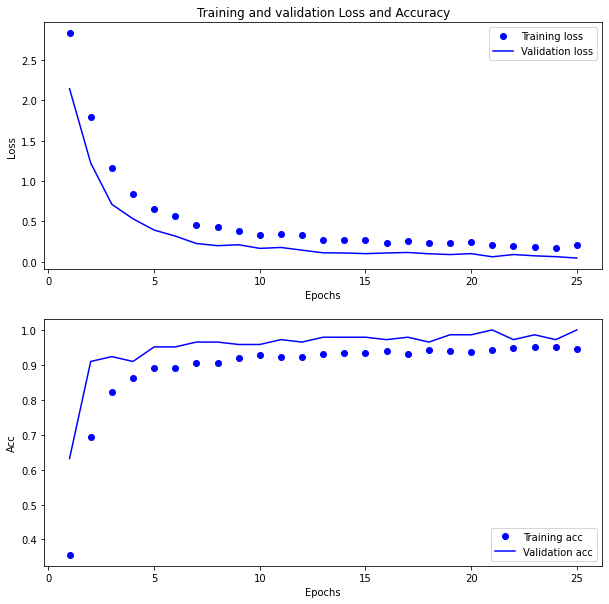

In [19]:
plot_training_curves(history)

In [20]:
print_metrics(model, test_generator)

10/10 [==============================] - 13s 1s/step - loss: 0.0934 - accuracy: 0.9667 - auc: 0.9999
Test loss: 0.09342879056930542
Test accuracy: 0.9666666388511658
Test ROC AUC: 0.999927282333374


Classification Report
                        precision    recall  f1-score   support

 DARJEELING WOODPECKER       1.00      1.00      1.00         5
     BARROWS GOLDENEYE       1.00      1.00      1.00         5
         MARABOU STORK       0.83      1.00      0.91         5
              COCKATOO       1.00      1.00      1.00         5
        GOULDIAN FINCH       1.00      1.00      1.00         5
           HORNED LARK       1.00      1.00      1.00         5
     GOLD WING WARBLER       1.00      1.00      1.00         5
      STRIPPED SWALLOW       1.00      1.00      1.00         5
   ROSY FACED LOVEBIRD       1.00      1.00      1.00         5
        GREAT KISKADEE       1.00      1.00      1.00         5
       ARARIPE MANAKIN       1.00      1.00      1.00         5
       LESSER ADJUTANT       0.71      1.00      0.83         5
       NORTHERN JACANA       1.00      0.80      0.89         5
        SANDHILL CRANE       1.00      1.00      1.00         5
         ABBOTTS 

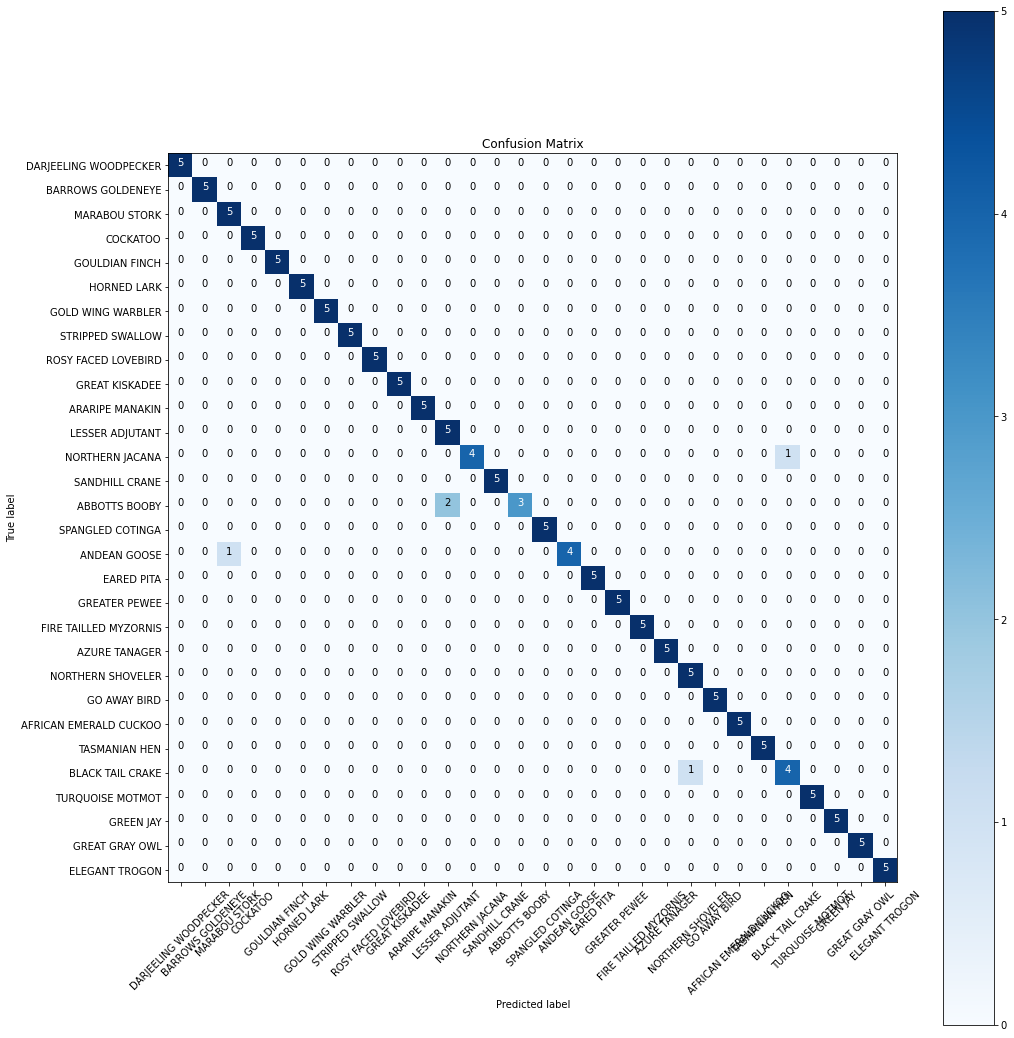

In [21]:
plot_confusion_matrix_and_classification_report(model, test_generator, classes)

# Resultados com ResNet50
```
Test loss: 0.1234726831316948
Test accuracy: 0.9866666793823242
Test ROC AUC: 0.9999072551727295
```
```
Classification Report
                        precision    recall  f1-score   support

       RED HEADED DUCK       1.00      1.00      1.00         5
            PINK ROBIN       1.00      1.00      1.00         5
   RED FACED CORMORANT       1.00      1.00      1.00         5
       BARRED PUFFBIRD       0.83      1.00      0.91         5
              WHIMBREL       1.00      1.00      1.00         5
          WALL CREAPER       1.00      1.00      1.00         5
      EVENING GROSBEAK       1.00      1.00      1.00         5
         MOURNING DOVE       1.00      1.00      1.00         5
     NORTHERN CARDINAL       1.00      1.00      1.00         5
 RED BEARDED BEE EATER       1.00      1.00      1.00         5
       RUDY KINGFISHER       1.00      1.00      1.00         5
  NORTHERN MOCKINGBIRD       1.00      1.00      1.00         5
               QUETZAL       1.00      1.00      1.00         5
BLACK THROATED WARBLER       1.00      1.00      1.00         5
  BLACKBURNIAM WARBLER       1.00      0.80      0.89         5
                PUFFIN       1.00      1.00      1.00         5
      TURQUOISE MOTMOT       1.00      1.00      1.00         5
      NORTHERN FLICKER       1.00      1.00      1.00         5
      EASTERN BLUEBIRD       1.00      1.00      1.00         5
       SCARLET TANAGER       1.00      1.00      1.00         5
         CEDAR WAXWING       1.00      1.00      1.00         5
                CANARY       0.83      1.00      0.91         5
 AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
          MAGPIE GOOSE       1.00      1.00      1.00         5
   VERMILION FLYCATHER       1.00      1.00      1.00         5
                 ROBIN       1.00      1.00      1.00         5
       COMMON POORWILL       1.00      1.00      1.00         5
      BANDED BROADBILL       1.00      1.00      1.00         5
        HAWAIIAN GOOSE       1.00      1.00      1.00         5
  RED WINGED BLACKBIRD       1.00      0.80      0.89         5

              accuracy                           0.99       150
             macro avg       0.99      0.99      0.99       150
          weighted avg       0.99      0.99      0.99       150
```